In [1]:
#importing libraries needed for the models 

import numpy as np
import pandas as pd
import datetime

from matplotlib import pyplot as plt
from sklearn import linear_model
from statsmodels.formula.api import poisson,ols,negativebinomial
from sklearn import metrics

from scipy.special import logsumexp

import scipy.special as spsp
import scipy.stats as spst

from statsmodels.base.model import GenericLikelihoodModel

!pip install yfinance
import yfinance as yf
import pandas_datareader.data as pdr

In [3]:
df = pd.read_csv("cleaned_datewise_data.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df

,DATE,count,Temperature,Visibility,Cloud Cover,humidity,Conditions,DJI,Precipitation,Snow,...,JHI_lag,MPGSX_lag,TJX_lag,TMO_lag,JHI_7_lag,MPGSX_7_lag,TJX_7_lag,TMO_7_lag,BCG_7_lag,t
0,2018-01-01,48,5.6,9.9,15.0,48.02,Clear,24824.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2018-01-02,13,11.6,9.9,25.6,53.38,Partially cloudy,24824.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2018-01-03,61,21.8,9.9,53.4,54.99,Partially cloudy,24922.68,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,2018-01-04,10,25.9,4.5,87.0,78.59,"Snow, Overcast",25075.13,0.62,6.67,...,12.898993,8.150966,36.429710,191.056091,NaN,NaN,NaN,NaN,NaN,3
4,2018-01-05,20,14.2,8.4,57.1,53.83,"Snow, Partially cloudy",25295.87,0.00,4.00,...,12.898993,8.150966,36.429710,191.056091,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2021-10-15,15,64.6,9.9,80.2,88.48,Overcast,35294.76,0.00,0.00,...,18.223978,15.600000,62.735744,575.678223,18.214185,15.657143,63.488650,579.041129,20285.714286,1116
1117,2021-10-16,12,69.8,9.9,90.5,80.83,Overcast,35258.61,0.00,0.00,...,18.204393,15.700000,63.263775,573.329163,18.235169,15.668571,63.370519,578.749817,20585.714286,1117
1118,2021-10-17,17,59.3,9.7,57.1,67.35,"Rain, Partially cloudy",35258.61,0.33,0.00,...,18.223978,16.000000,63.901390,577.117615,18.232371,15.698571,63.250965,577.870170,20621.428571,1118
1119,2021-10-18,14,53.9,9.9,61.3,57.28,Partially cloudy,35258.61,0.00,0.00,...,18.184807,16.110001,64.110611,582.155640,18.228174,15.752857,63.195457,577.651690,20657.142857,1119


Text(0.5, 1.0, 'Log(Count)')

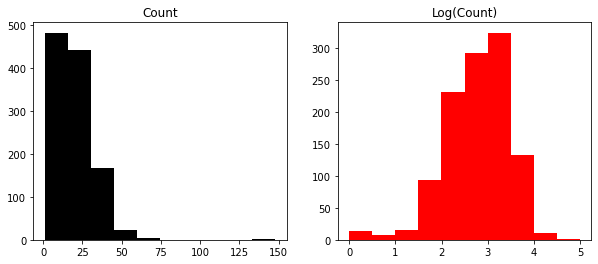

In [4]:
#analyzing the distribution of assault counts based on 'DATE'. Since it has a right tail, we take log to get a normal distribution

fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(df['count'],color='k')
ax[0].set_title("Count")
ax[1].hist(np.log(df['count']),color='red')
ax[1].set_title("Log(Count)")

Text(0.5, 1.0, 'Log(Count)')

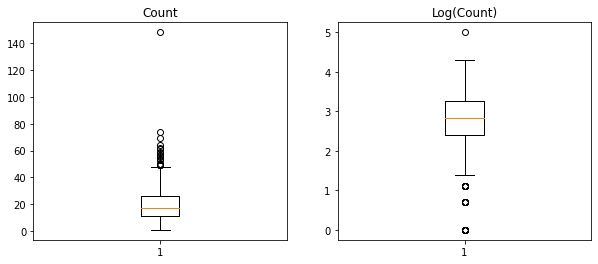

In [5]:
#analyzing the range of values in the 'count' column, and the outliers. It can be clearly seen that taking log helps us de-emphasize the outliers and allows us to obtain a bell shaped curve

fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].boxplot(df['count'])
ax[0].set_title("Count")
ax[1].boxplot(np.log(df['count']))
ax[1].set_title("Log(Count)")



In [6]:
df

,DATE,count,Temperature,Visibility,Cloud Cover,humidity,Conditions,DJI,Precipitation,Snow,...,JHI_lag,MPGSX_lag,TJX_lag,TMO_lag,JHI_7_lag,MPGSX_7_lag,TJX_7_lag,TMO_7_lag,BCG_7_lag,t
0,2018-01-01,48,5.6,9.9,15.0,48.02,Clear,24824.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2018-01-02,13,11.6,9.9,25.6,53.38,Partially cloudy,24824.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2018-01-03,61,21.8,9.9,53.4,54.99,Partially cloudy,24922.68,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,2018-01-04,10,25.9,4.5,87.0,78.59,"Snow, Overcast",25075.13,0.62,6.67,...,12.898993,8.150966,36.429710,191.056091,NaN,NaN,NaN,NaN,NaN,3
4,2018-01-05,20,14.2,8.4,57.1,53.83,"Snow, Partially cloudy",25295.87,0.00,4.00,...,12.898993,8.150966,36.429710,191.056091,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2021-10-15,15,64.6,9.9,80.2,88.48,Overcast,35294.76,0.00,0.00,...,18.223978,15.600000,62.735744,575.678223,18.214185,15.657143,63.488650,579.041129,20285.714286,1116
1117,2021-10-16,12,69.8,9.9,90.5,80.83,Overcast,35258.61,0.00,0.00,...,18.204393,15.700000,63.263775,573.329163,18.235169,15.668571,63.370519,578.749817,20585.714286,1117
1118,2021-10-17,17,59.3,9.7,57.1,67.35,"Rain, Partially cloudy",35258.61,0.33,0.00,...,18.223978,16.000000,63.901390,577.117615,18.232371,15.698571,63.250965,577.870170,20621.428571,1118
1119,2021-10-18,14,53.9,9.9,61.3,57.28,Partially cloudy,35258.61,0.00,0.00,...,18.184807,16.110001,64.110611,582.155640,18.228174,15.752857,63.195457,577.651690,20657.142857,1119


Text(0, 0.5, 'Price')

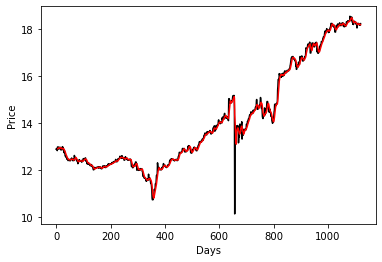

In [7]:
### ROLLING AVERAGE COMPARION

plt.plot(df['JHI'],color='k')
plt.plot(df['JHI_7'],color='red')
plt.xlabel("Days")
plt.ylabel("Price")

<AxesSubplot:>

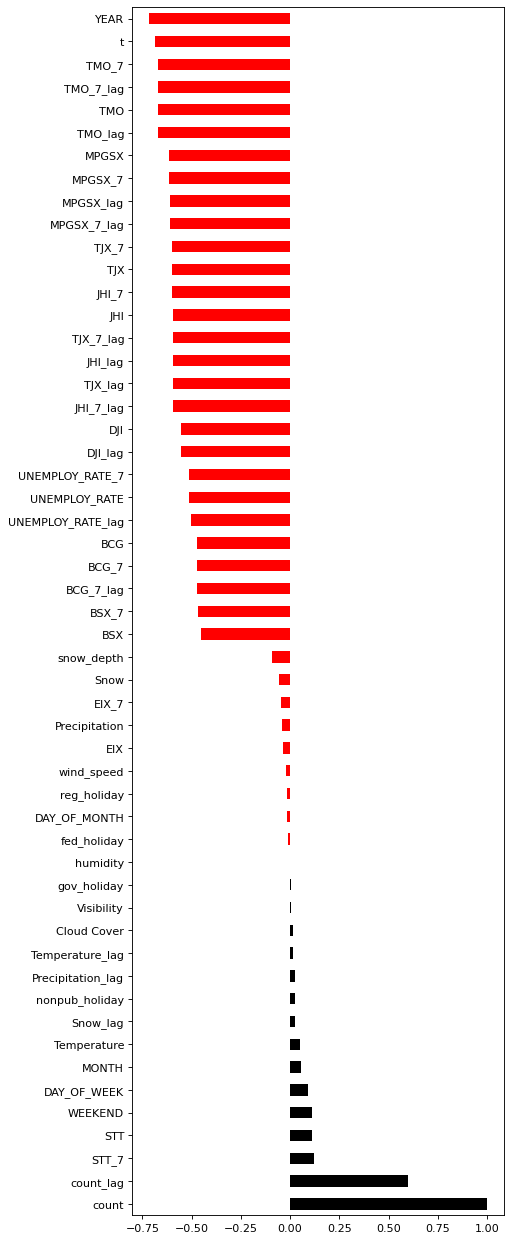

In [8]:
#Checking the correlation of features with count

from matplotlib.pyplot import figure

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }
df_corr = df.copy().corr()

figure(figsize=(6, 20), dpi=80)

df_corr = df_corr.sort_values('count',ascending=False)
df_corr['value'] = df_corr['count']>=0
df_corr['count'].plot.barh(color=df_corr.value.map({True: 'k', False: 'red'}))

In [9]:
#CAUSAL INFERENCE

ols_features = 'np.log(count)~np.log(count_lag)+Temperature+Precipitation+C(MONTH)+C(WEEKEND)+I(UNEMPLOY_RATE)\
+JHI_7+MPGSX_7+TJX_7+TMO_7+BCG+Snow'

df_ols = ols(ols_features, df).fit()
pred_ols = df_ols.predict()
print(df_ols.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(count)   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     93.52
Date:                Fri, 31 Dec 2021   Prob (F-statistic):          6.90e-233
Time:                        20:32:29   Log-Likelihood:                -587.51
No. Observations:                1115   AIC:                             1221.
Df Residuals:                    1092   BIC:                             1336.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.0985      0.30

Text(0, 0.5, 'R Score')

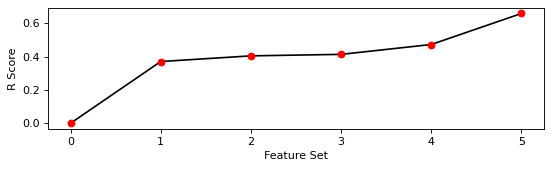

In [10]:
### R SCORE COMPARISON

figure(figsize=(8, 2), dpi=80)
tick_x = [0,1,2,3,4,5]
r_score_list = [0,0.370, 0.404, 0.413, 0.472, 0.658]
plt.plot(r_score_list,color='k',marker='o',markerfacecolor='red',markeredgecolor='red')
plt.xticks(ticks=tick_x)
plt.xlabel('Feature Set')
plt.ylabel('R Score')

In [11]:
import datetime

dates = ['2021-08-20']
dates_list = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
a = np.array(dates_list, dtype='datetime64')


In [12]:
### TIME-SERIES PREDICTION

train = df[df['DATE']<=a[0]]
test = df[df['DATE']>=a[0]].head(28)
test_Y = df[df['DATE']>=a[0]]['count'].head(28)

ols_features_lag = 'np.log(count)~np.log(count_lag)+Temperature_lag+Precipitation_lag+C(WEEKEND)+C(MONTH)+I(UNEMPLOY_RATE_lag**4)\
+JHI_7_lag+MPGSX_7_lag+TJX_7_lag+TMO_7_lag+BCG_7_lag+C(DAY_OF_WEEK)'

pred_model = ols(ols_features_lag, train).fit()
pred = np.exp(pred_model.predict(test))
rscore = metrics.r2_score(test_Y,pred)

print(pred_model.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(count)   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     71.89
Date:                Fri, 31 Dec 2021   Prob (F-statistic):          3.88e-210
Time:                        20:32:31   Log-Likelihood:                -577.81
No. Observations:                1052   AIC:                             1210.
Df Residuals:                    1025   BIC:                             1344.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

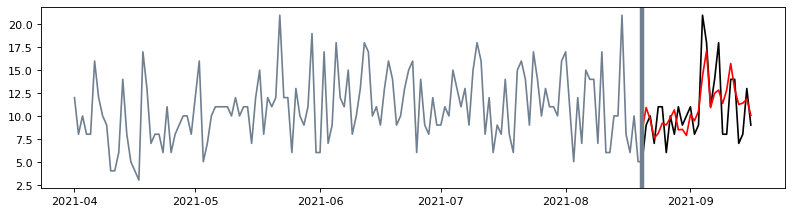

In [13]:
figure(figsize=(12, 3), dpi=80)

dt_mask = ['2021-04-01']
dt_mask = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dt_mask]
a_mask = np.array(dt_mask, dtype='datetime64')

plt.plot(train[train['DATE']>=a_mask[0]]['DATE'],train[train['DATE']>=a_mask[0]]['count'],color='slategrey',label='Historical')
plt.plot(test['DATE'],test_Y,color="black",label="Actual")
plt.plot(test['DATE'],pred,color="red",label="Predicted")
plt.axvline(x=a[0],linewidth=4,color='slategrey')

In [14]:
#BASELINE POISSON

class Poisson_M(GenericLikelihoodModel):

    def loglike(self, params):

        y=self.endog
        lmbda=np.exp(params[0])
        return np.sum(spst.poisson.logpmf(y,lmbda))

poisson_baseline = Poisson_M(df["count"]).fit(start_params=5+np.random.rand()*1,maxiter=10000)
print(poisson_baseline.summary(xname=["Intercept"]))

Optimization terminated successfully.
         Current function value: 5.798291
         Iterations: 18
         Function evaluations: 36
                              Poisson_M Results                               
Dep. Variable:                  count   Log-Likelihood:                -6499.9
Model:                      Poisson_M   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Fri, 31 Dec 2021                                         
Time:                        20:32:31                                         
No. Observations:                1121                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [15]:
m6 = poisson("count~1",df).fit()
print(m6.summary())

Optimization terminated successfully.
         Current function value: 5.798291
         Iterations 1
                          Poisson Regression Results                          
Dep. Variable:                  count   No. Observations:                 1121
Model:                        Poisson   Df Residuals:                     1120
Method:                           MLE   Df Model:                            0
Date:                Fri, 31 Dec 2021   Pseudo R-squ.:                   0.000
Time:                        20:32:31   Log-Likelihood:                -6499.9
converged:                       True   LL-Null:                       -6499.9
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9873      0.007    445.403      0.000       2.974       3.000


In [16]:
print(np.exp(m6.params[0]))
print(np.exp(poisson_baseline.params[0]))
print(df['count'].mean())

19.831400535236394
19.831850841523035
19.831400535236398


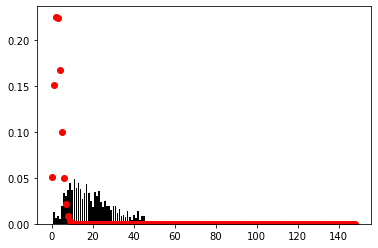

In [17]:
lm1 = poisson_baseline.params[0]

y_values, counts=np.unique(df["count"],return_counts=True)


plt.bar(y_values, counts/np.sum(counts),color='k')

y_a=np.arange(0,np.max(y_values)+1)
L1=spst.poisson.pmf(y_a,lm1)

plt.scatter(y_a,L1,zorder=2,color='red')
plt.show()

In [18]:
### Probability of 10 crimes happening?

print(spst.poisson.pmf(10,lm1))

### Probability of 15 crimes happening?

print(spst.poisson.pmf(15,lm1))

0.0007864054496354414
5.191541541592734e-07


In [19]:
### NBD

class Poisson_Mix(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        gamma=np.exp(params[0])
        alpha=np.exp(params[1])
        
        #Individual likelihood
        
        Likelihood=spst.nbinom.pmf(y,n=gamma,p=alpha/(1+alpha))
        #Likelihood=Likelihood/(1-spst.nbinom.pmf(0,n=gamma,p=alpha/(1+alpha)))
        LogLike=np.log(Likelihood)
        return np.sum(LogLike)
nbd_model_date=Poisson_Mix(df["count"]).fit(start_params=np.random.rand(2))
print(nbd_model_date.summary())

Optimization terminated successfully.
         Current function value: 3.783414
         Iterations: 62
         Function evaluations: 115
                             Poisson_Mix Results                              
Dep. Variable:                  count   Log-Likelihood:                -4241.2
Model:                    Poisson_Mix   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Fri, 31 Dec 2021                                         
Time:                        20:32:34                                         
No. Observations:                1121                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

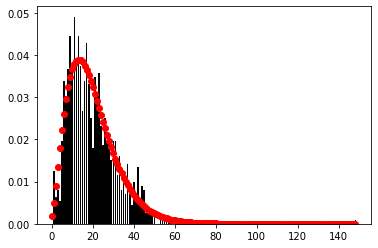

In [20]:
gamma,alpha=np.exp(nbd_model_date.params)
gamma,alpha

y_values, counts=np.unique(df["count"],return_counts=True)
plt.bar(y_values, counts/np.sum(counts),color='k')

# y_value array
y_a=np.arange(0,np.max(y_values)+1)
 
probs= spst.nbinom.pmf(y_a,n=gamma,p=alpha/(1+alpha))
plt.scatter(y_a,probs,zorder=2,color='red')
plt.show()

In [21]:
#NBD WITH TRUNCATION

class Poisson_Mix(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        gamma=np.exp(params[0])
        alpha=np.exp(params[1])
        #Individual likelihood
        
        Likelihood=spst.nbinom.pmf(y,n=gamma,p=alpha/(1+alpha))
        Likelihood=Likelihood/(1-spst.nbinom.pmf(0,n=gamma,p=alpha/(1+alpha)))
        LogLike=np.log(Likelihood)
        return np.sum(LogLike)

nbd_model=Poisson_Mix(df["count"]).fit(start_params=np.random.rand(2))
print(nbd_model.summary())

Optimization terminated successfully.
         Current function value: 3.781568
         Iterations: 54
         Function evaluations: 103
                             Poisson_Mix Results                              
Dep. Variable:                  count   Log-Likelihood:                -4239.1
Model:                    Poisson_Mix   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Fri, 31 Dec 2021                                         
Time:                        20:32:35                                         
No. Observations:                1121                                         
Df Residuals:                     NaN                                         
Df Model:                         NaN                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

3.1555571861801153 0.15942356273298913


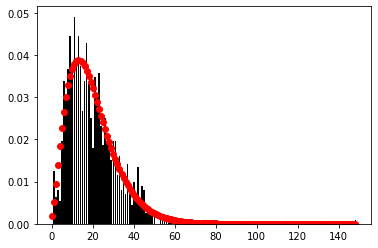

In [22]:
gamma,alpha=np.exp(nbd_model.params)
print(gamma,alpha)

y_values, counts=np.unique(df["count"],return_counts=True)
plt.bar(y_values, counts/np.sum(counts),color='k')
y_a=np.arange(0,np.max(y_values)+1)
 
probs= spst.nbinom.pmf(y_a,n=gamma,p=alpha/(1+alpha))
probs= probs/(1-spst.nbinom.pmf(0,n=gamma,p=alpha/(1+alpha)))
plt.scatter(y_a,probs,zorder=2,color='red')
plt.show()

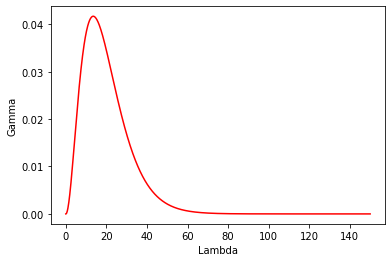

In [23]:
#distribution of lambda which follows a gamma distribution

lm_a=np.linspace(0,150,1000)
pdf_a=spst.gamma.pdf(lm_a, a=gamma,scale=1/alpha)
plt.plot(lm_a,pdf_a,color='red')
plt.xlabel('Lambda')
plt.ylabel('Gamma')
plt.show()


In [24]:
### Probability of 10 crimes happening?

probs10 = spst.nbinom.pmf(10,n=gamma,p=alpha/(1+alpha))
probs10 = probs10/(1-spst.nbinom.pmf(0,n=gamma,p=alpha/(1+alpha)))
print(probs10)

# ### Probability of 30 crimes happening?

probs30 = spst.nbinom.pmf(30,n=gamma,p=alpha/(1+alpha))
probs30 = probs30/(1-spst.nbinom.pmf(0,n=gamma,p=alpha/(1+alpha)))
print(probs30)

0.036773501316678
0.016630681022151067


In [25]:
AIC_1 = -2*nbd_model.llf+2*2
BIC_1 = -2*nbd_model.llf+np.log(df.shape[0])*2

print(AIC_1, BIC_1)

8482.27640954635 8492.320362392495


In [26]:
df

,DATE,count,Temperature,Visibility,Cloud Cover,humidity,Conditions,DJI,Precipitation,Snow,...,JHI_lag,MPGSX_lag,TJX_lag,TMO_lag,JHI_7_lag,MPGSX_7_lag,TJX_7_lag,TMO_7_lag,BCG_7_lag,t
0,2018-01-01,48,5.6,9.9,15.0,48.02,Clear,24824.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2018-01-02,13,11.6,9.9,25.6,53.38,Partially cloudy,24824.01,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2018-01-03,61,21.8,9.9,53.4,54.99,Partially cloudy,24922.68,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,2018-01-04,10,25.9,4.5,87.0,78.59,"Snow, Overcast",25075.13,0.62,6.67,...,12.898993,8.150966,36.429710,191.056091,NaN,NaN,NaN,NaN,NaN,3
4,2018-01-05,20,14.2,8.4,57.1,53.83,"Snow, Partially cloudy",25295.87,0.00,4.00,...,12.898993,8.150966,36.429710,191.056091,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2021-10-15,15,64.6,9.9,80.2,88.48,Overcast,35294.76,0.00,0.00,...,18.223978,15.600000,62.735744,575.678223,18.214185,15.657143,63.488650,579.041129,20285.714286,1116
1117,2021-10-16,12,69.8,9.9,90.5,80.83,Overcast,35258.61,0.00,0.00,...,18.204393,15.700000,63.263775,573.329163,18.235169,15.668571,63.370519,578.749817,20585.714286,1117
1118,2021-10-17,17,59.3,9.7,57.1,67.35,"Rain, Partially cloudy",35258.61,0.33,0.00,...,18.223978,16.000000,63.901390,577.117615,18.232371,15.698571,63.250965,577.870170,20621.428571,1118
1119,2021-10-18,14,53.9,9.9,61.3,57.28,Partially cloudy,35258.61,0.00,0.00,...,18.184807,16.110001,64.110611,582.155640,18.228174,15.752857,63.195457,577.651690,20657.142857,1119


In [27]:
df = df.dropna()

In [28]:
df

,DATE,count,Temperature,Visibility,Cloud Cover,humidity,Conditions,DJI,Precipitation,Snow,...,JHI_lag,MPGSX_lag,TJX_lag,TMO_lag,JHI_7_lag,MPGSX_7_lag,TJX_7_lag,TMO_7_lag,BCG_7_lag,t
9,2018-01-10,23,30.7,9.9,24.4,61.78,Clear,25369.13,0.00,0.0,...,12.994270,8.357157,35.935684,200.699036,12.919933,8.261425,36.140623,196.491381,6050.000000,9
10,2018-01-11,42,42.5,9.9,85.3,86.77,Overcast,25574.73,0.00,0.0,...,12.994270,8.357157,35.935684,200.699036,12.933544,8.290881,36.070048,197.868944,6024.285714,10
11,2018-01-12,31,52.4,6.2,86.0,97.04,"Rain, Overcast",25803.19,0.48,0.0,...,12.994270,8.376487,35.864433,204.045334,12.947155,8.323098,35.989294,199.724551,6004.285714,11
12,2018-01-13,35,43.2,8.5,58.2,74.88,"Rain, Partially cloudy",25792.86,1.38,0.0,...,12.928308,8.363600,36.230202,204.233429,12.947155,8.343349,36.054440,201.106352,5990.000000,12
13,2018-01-14,45,17.9,9.9,55.8,48.04,Partially cloudy,25792.86,0.00,0.0,...,12.898993,8.440921,36.519966,206.579819,12.949249,8.370043,36.152839,202.475427,5981.428571,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2021-10-15,15,64.6,9.9,80.2,88.48,Overcast,35294.76,0.00,0.0,...,18.223978,15.600000,62.735744,575.678223,18.214185,15.657143,63.488650,579.041129,20285.714286,1116
1117,2021-10-16,12,69.8,9.9,90.5,80.83,Overcast,35258.61,0.00,0.0,...,18.204393,15.700000,63.263775,573.329163,18.235169,15.668571,63.370519,578.749817,20585.714286,1117
1118,2021-10-17,17,59.3,9.7,57.1,67.35,"Rain, Partially cloudy",35258.61,0.33,0.0,...,18.223978,16.000000,63.901390,577.117615,18.232371,15.698571,63.250965,577.870170,20621.428571,1118
1119,2021-10-18,14,53.9,9.9,61.3,57.28,Partially cloudy,35258.61,0.00,0.0,...,18.184807,16.110001,64.110611,582.155640,18.228174,15.752857,63.195457,577.651690,20657.142857,1119


In [29]:
#NBD WITH COVARIATES

class Poisson_Mix(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        x=self.exog
        gamma=np.exp(params[0])
        alpha=np.exp(params[1])/np.exp(params[2]*x[:,0]+params[3]*x[:,1]+params[4]*x[:,2]+params[5]*x[:,3])
        
        Likelihood=spst.nbinom.pmf(y,n=gamma,p=alpha/(1+alpha))
        Likelihood=Likelihood/(1-spst.nbinom.pmf(0,n=gamma,p=alpha/(1+alpha)))
        LogLike=np.log(Likelihood)
        return np.sum(LogLike)

nbd_cov=Poisson_Mix(df["count"],df[['Temperature','TJX_7','TMO_7','BCG_7']]).fit(start_params=[nbd_model_date.params[0],nbd_model_date.params[1],0,0,0,0])
print(nbd_cov.summary(xname=["log_gamma","log_alpha","Temperature",'TJX','TMO','BCG']))


Optimization terminated successfully.
         Current function value: 3.284295
         Iterations: 386
         Function evaluations: 600
                             Poisson_Mix Results                              
Dep. Variable:                  count   Log-Likelihood:                -3652.1
Model:                    Poisson_Mix   AIC:                             7312.
Method:            Maximum Likelihood   BIC:                             7332.
Date:                Fri, 31 Dec 2021                                         
Time:                        20:32:37                                         
No. Observations:                1112                                         
Df Residuals:                    1108                                         
Df Model:                           3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [30]:
AIC_2 = -2*nbd_cov.llf+2*7
BIC_2 = -2*nbd_cov.llf+np.log(df.shape[0])*7

print(AIC_2, BIC_2)

7318.272640336067 7353.37004865974


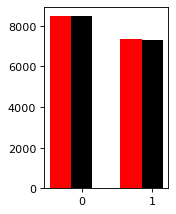

In [31]:
### AIC, BIC COMPARISON

figure(figsize=(2, 3), dpi=80)

selection1 = [AIC_1, AIC_2]
selection2 = [BIC_1, BIC_2]

plt.bar(np.arange(0,2), selection1,width=0.3,label="BIC",color='k')
plt.bar(np.arange(0,2)-0.3, selection2,width=0.3,label="AIC",color='red')

plt.show()